# ASTR777 Star and Planet Formation Problem Set 1
## explore the IRAM 30m Orion data cube of 12CO and 13CO from https://www.iram.fr/ILPA/LP014

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
# basic modules for reading data and plotting images
from astropy.io import ascii, fits
from astropy.wcs import WCS
from astropy.visualization import (ImageNormalize, MinMaxInterval, SqrtStretch, LogStretch, AsinhStretch)

## read in the data and examine header

In [3]:
# read in the fits file and get some basic information
hdu = fits.open('iram30m/orionA_12co.fits')
hdu.info()

Filename: iram30m/orionA_12co.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      45   (689, 575, 461)   float32   


In [4]:
# create data array and header
im = hdu[0].data
hd = hdu[0].header

In [5]:
# look at the header
# note its RA-DEC-velocity in deg, deg, m/s
# and units of K for antenna temperature (equivalent to intensity)
print(hd)

SIMPLE  =                    T         /                                        BITPIX  =                  -32         /                                        NAXIS   =                    3         /                                        NAXIS1  =                  689         /                                        NAXIS2  =                  575         /                                        NAXIS3  =                  461         /                                        DATAMIN = -0.1000000305176E+04         /                                        DATAMAX =  0.1113397979736E+03         /                                        BUNIT   = 'K (Ta*)     '               /                                        CTYPE1  = 'RA---GLS    '               /                                        CRVAL1  =  0.8381037499999E+02         /                                        CDELT1  = -0.1482040576252E-02         /                                        CRPIX1  =  0.3455622898947E+03         /

## plot a map of the peak temperature

In [6]:
# get the peak value at each ra-dec position (note that velocity is axis 0 of the python array)
# im.shape
# note use of nanmax (try np.max and see what happens)
peak = np.nanmax(im, axis=0)

<ipython-input-6-eeae4fd5a5bc>:4: RuntimeWarning: All-NaN slice encountered
  peak = np.nanmax(im, axis=0)


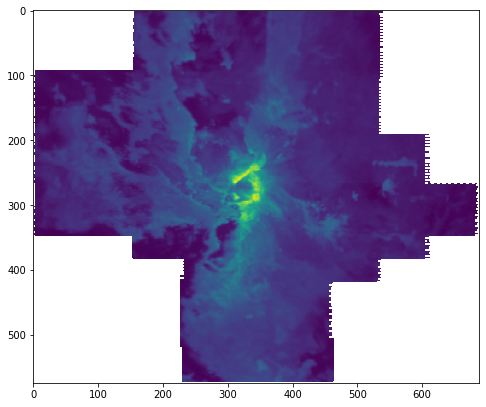

In [7]:
# first basic plot
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.imshow(peak)

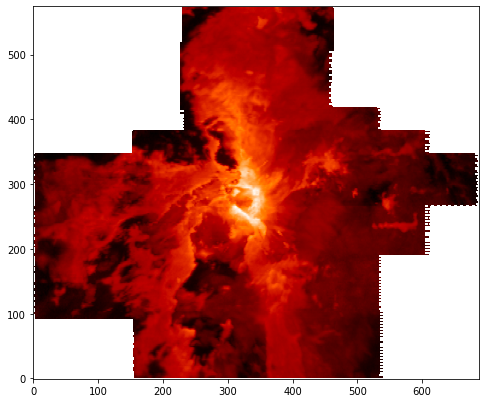

In [8]:
# fix the orientation and scale better so that it looks more like the website image
# https://www.iram-institute.org/EN/content-page-378-7-158-240-378-0.html
# for image scaling see https://docs.astropy.org/en/stable/visualization/normalization.html
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
norm = ImageNormalize(peak, interval=MinMaxInterval(), stretch=AsinhStretch())
ax.imshow(peak, origin='lower', norm=norm, cmap='gist_heat')

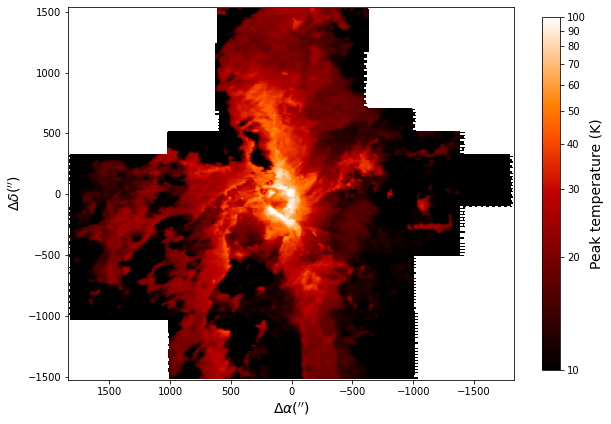

In [9]:
# plot again but now with offset equatorial coordinates rather than pixels
# and user-defined scaling with an intensity scalebar
ra  = (1 + np.arange(hd['NAXIS1']) - hd['CRPIX1']) * hd['CDELT1'] * 3600
dec = (1 + np.arange(hd['NAXIS2']) - hd['CRPIX2']) * hd['CDELT2'] * 3600
extent =[np.max(ra), np.min(ra), np.min(dec), np.max(dec)]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
norm = ImageNormalize(peak, vmin=10, vmax=100, stretch=AsinhStretch())
p = ax.imshow(peak, origin='lower', norm=norm, cmap='gist_heat', extent=extent)
ax.set_xlabel(r"$\Delta\alpha ('')$", fontsize=14)
ax.set_ylabel(r"$\Delta\delta ('')$", fontsize=14)

c = plt.colorbar(p, ax=ax, shrink=0.65)
c.set_label('Peak temperature (K)', fontsize=14)

## plot channel maps and write them out to make a movie

15.014369190141363 2.823082805082362


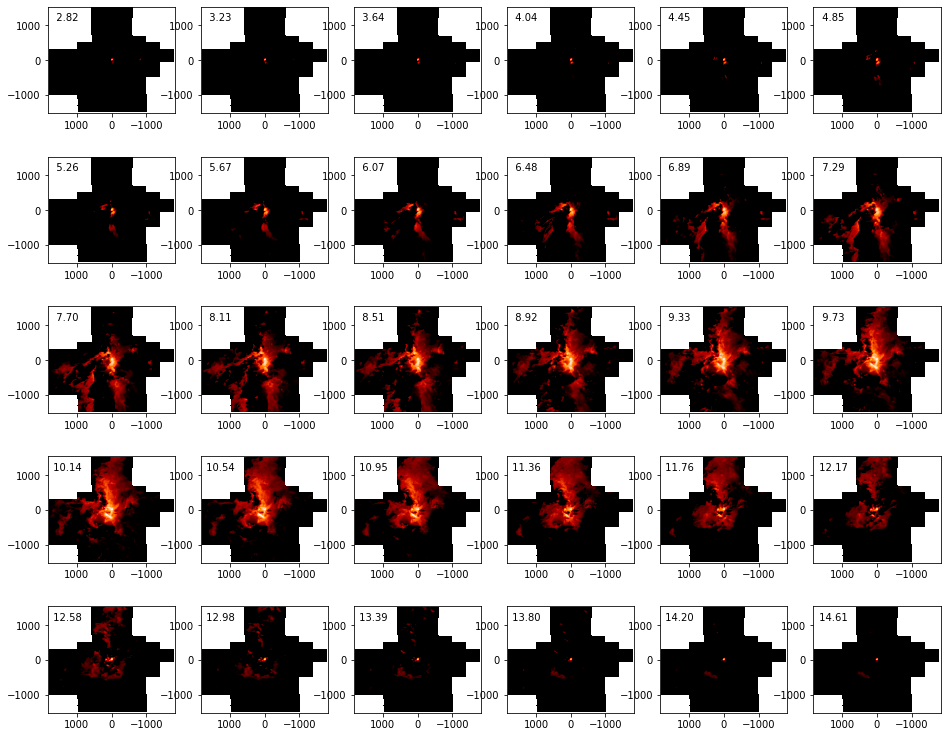

In [20]:
# now go through the velocity axis and look at the "channels" one by one

# first define velocity axis (ote that python arrays start at index zero but convention for FITS is to start at 1)
v = hd['CRVAL3'] + (1 + np.arange(hd['NAXIS3']) - hd['CRPIX3']) * hd['CDELT3']
v /= 1000    # convert to km/s
nv = v.size

# range of indices (chosen by eye playing around with other image visualization tools)
k0 = 215
k1 = 245
#print(v[k0], v[k1])
nplot = k1 - k0
ny = int(np.fix(np.sqrt(nplot)))
nx = int(np.fix(nplot/ny + 0.99))
sx = 16
fig = plt.figure(figsize=(sx,sx*ny/nx))
for n in range(nplot):
    cube_index = k1-n        # reverse order since v decreases with index (CDELT3 is negative)
    ax = plt.subplot(ny, nx, n+1)
    im1 = im[cube_index, :, :]
    norm = ImageNormalize(im1, vmin=10, vmax=100, stretch=AsinhStretch())
    ax.imshow(im1, origin='lower', norm=norm, cmap='gist_heat', extent=extent)
    ax.text(0.02, 0.87, f'{v[cube_index]:6.2f}', fontsize=10, transform = ax.transAxes)

In [22]:
# make a movie of the channel maps, expanded a bit in range
# first create a bunch of png in a directory

k0 = 200
k1 = 260
#print(v[k0], v[k1])
for k in range(k1, k0, -1):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    im1 = im[k,:,:]
    norm = ImageNormalize(im1, vmin=10, vmax=100, stretch=AsinhStretch())
    ax.imshow(im1, origin='lower', norm=norm, cmap='gist_heat', extent=extent)
    ax.set_xlabel(r"$\Delta\alpha ('')$", fontsize=14)
    ax.set_ylabel(r"$\Delta\delta ('')$", fontsize=14)
    ax.text(0.03, 0.92, f'{v[k]:6.2f} km/s', fontsize=18, transform = ax.transAxes)
    plt.savefig(f'slices/{k1-k:02g}.png')
    plt.close()


21.110012382670863 -3.272560387447138


#### and then run ffmpeg (on the unix command line outside of the notebook)
#### see https://stackoverflow.com/questions/24961127/how-to-create-a-video-from-images-with-ffmpeg

> ffmpeg -framerate 10 -pattern_type glob -i '*.png' -c:v libx264 -pix_fmt yuv420p channels.mp4

#### there is a way to do this using matplotlib animator but I haven't been able to figure it out...

## now look at spectra, i.e., temperature vs velocity, and calculate Mach number

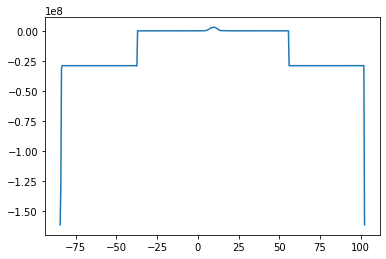

In [12]:
# basic first try 
Tsum = np.nansum(im, axis=(1,2))
plt.plot(v,Tsum)

(-3.0, 30.0)

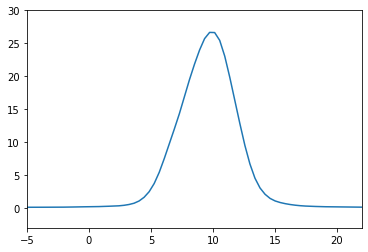

In [13]:
# lots of bad pixels corrupting things
# let's just concentrate on the center - this is a bit of a hack :)
map_region = [-500, 500, -500, 500]
imax = np.where(ra > map_region[0])[0][-1]
imin = np.where(ra < map_region[1])[0][0]
jmin = np.where(dec > map_region[2])[0][0]
jmax = np.where(dec < map_region[3])[0][-1]

Tsum = np.nansum(im[:, jmin:jmax, imin:imax], axis=(1,2))
Tave = Tsum / (imax-imin) / (jmax-jmin)
plt.plot(v,Tave)
plt.xlim(-5,22)
plt.ylim(-3,30)

In [23]:
# measure systemic velocity and linewidth
signal = (v > 0) & (v < 18)
v_mean = np.sum(v[signal] * Tave[signal]) / np.sum(Tave[signal])
v_sigma = np.sqrt(np.sum(v[signal]**2 * Tave[signal]) / np.sum(Tave[signal]) - v_mean**2)
print(f'Mean velocity = {v_mean:5.2f} km/s')
print(f'FWHM = {2.355*v_sigma:5.2f} km/s')

Mean velocity =  9.56 km/s
FWHM =  5.32 km/s


In [24]:
# compare with thermal linewidth
from astropy import units as u
from astropy import constants as c
T_kin = 10 * u.K
m_CO = 28 * c.m_p
v_thermal = np.sqrt(c.k_B * T_kin / m_CO)
print(f'Thermal velocity dispersion = {v_thermal.si:5.2f}')

Thermal velocity dispersion = 54.30 m / s


In [25]:
# Mach number of cloud => motions are highly non-thermal
M = v_sigma / (v_thermal.si.value/1000)
print(f'Mach number = {M:5.2f}')

Mach number = 41.60


## calculate virial mass

In [41]:
dist = 412        # distance to Trapezium Cluster in pc
R = 500 * dist    # "radius" of the region over which we measured the spectrum in au
Mvir = 5*R*u.au * (v_sigma*u.km/u.s)**2 / c.G
#print(Mvir)

In [45]:
print(f'Virial mass = {int((Mvir/c.M_sun).decompose()):5d} solar masses')

Virial mass =  5924 solar masses
